In [1]:
# core
import pandas as pd
import numpy as np


# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# for geoclustering
from sklearn.cluster import KMeans

# for scaling
from sklearn.preprocessing import RobustScaler

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#000000'>
    
# **1. Data Cleaning**</font>
</a>


In [2]:
# import train_df.parquet as df
df = pd.read_parquet('../data/initial_dfs/train_df.parquet')
# show all columns
pd.set_option('display.max_columns', None)
df.head(2)

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason,ID,Population
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6518-PPLMZ,Male,38,No,No,Yes,Yes,3,United States,California,Clio,96106,"39.745805, -120.580882",39.745805,-120.580882,Yes,8,53,None,Yes,25.32,No,No,None,0,No,No,No,No,No,No,No,No,Two Year,Yes,Credit Card,19.40,1110.35,0.0,0,1341.96,2452.31,Q3,3,Stayed,No,0,73,4497,None,None,1636,88
0060-FUALY,Female,60,No,No,Yes,No,0,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Yes,4,59,Offer B,Yes,16.39,Yes,Yes,Fiber Optic,14,Yes,Yes,No,No,Yes,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,94.75,5597.65,0.0,0,967.01,6564.66,Q3,3,Stayed,No,0,26,5238,None,None,3,58198


### 1.1. Checking nulls

In [3]:
# check null values in all columns. show only columns with null values
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]
print(null_counts)

Offer             2320
Internet Type      947
Churn Category    3104
Churn Reason      3104
dtype: int64


**All null values have a business explanation**:

- Null 'Churn Reason' and 'Churn Category' --> Customers with no churn

- Null 'Offer' --> Customers with no offer

- Internet Type --> Customers with no internet service

### 1.2. Selecting appropriate bins

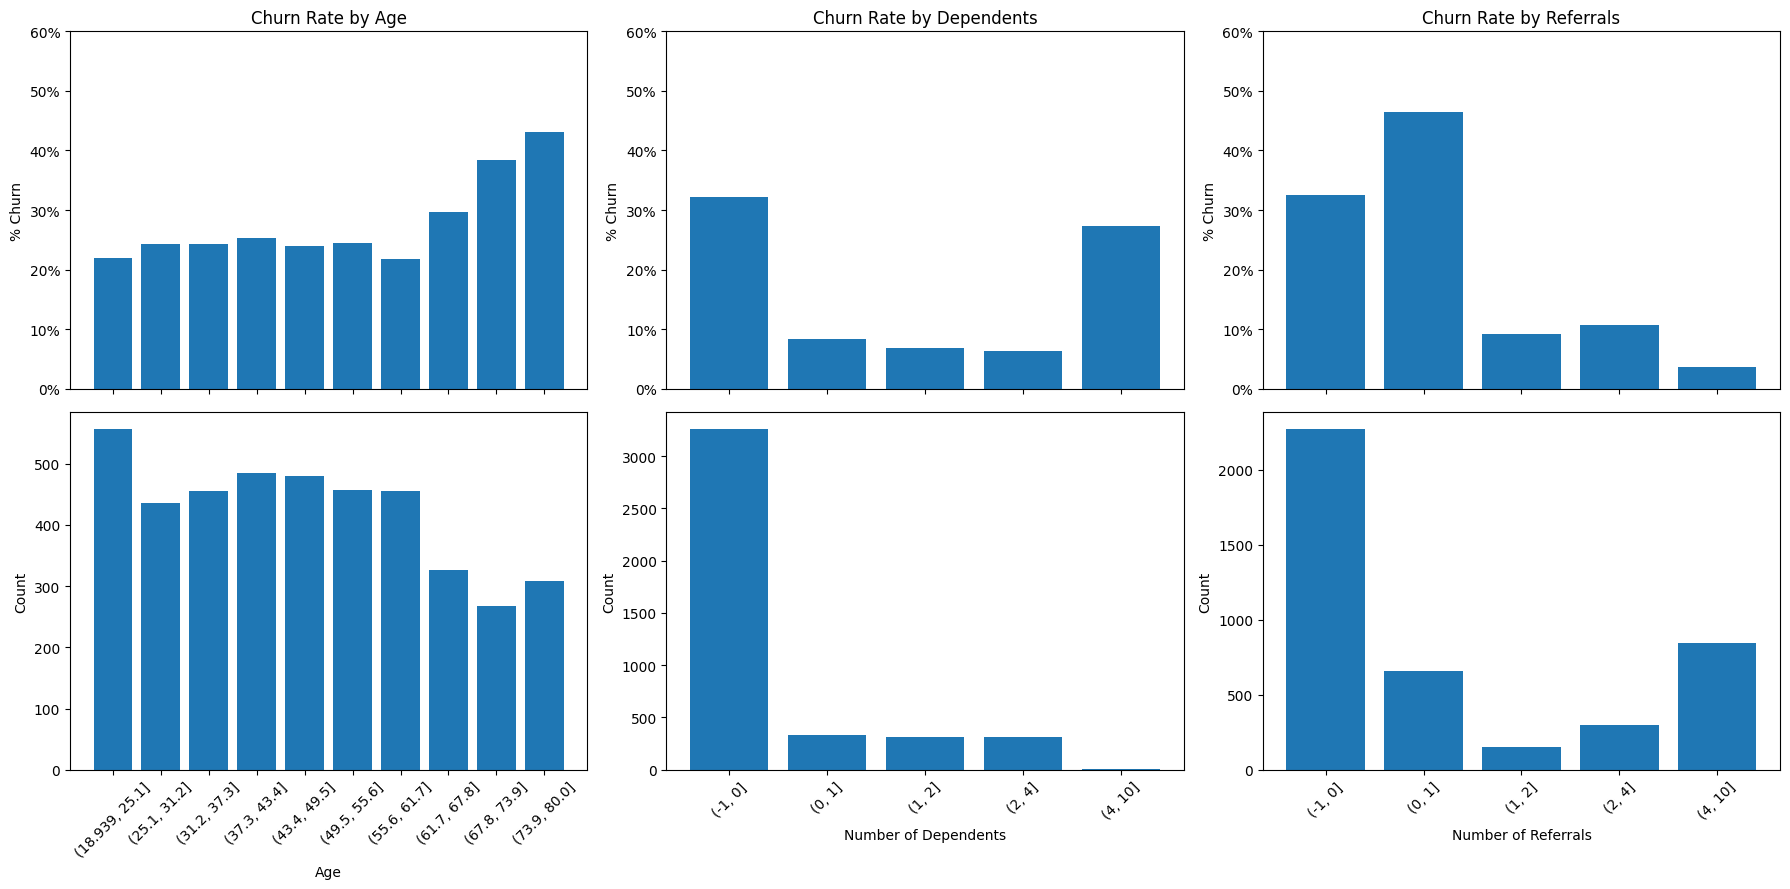

In [4]:
# plot 3 x 2 histograms with y axis average 'Churn Value' and Counts and x-axis given by each of the following collumn value - 'Age', 'Number of Dependents', and 'Number of Referrals'

fig, axs = plt.subplots(2, 3, figsize=(18, 9), sharex='col')

configs = [
    {
        "col": "Age",
        "bins": 10,
        "xlabel": "Age",
        "title": "Churn Rate by Age"
    },
    {
        "col": "Number of Dependents",
        "bins": [-1, 0, 1, 2, 4, 10],
        "xlabel": "Number of Dependents",
        "title": "Churn Rate by Dependents"
    },
    {
        "col": "Number of Referrals",
        "bins": [-1, 0, 1, 2, 4, 10],
        "xlabel": "Number of Referrals",
        "title": "Churn Rate by Referrals"
    }
]

for i, cfg in enumerate(configs):

    col = cfg["col"]
    bins = cfg["bins"]

    binned = pd.cut(df[col], bins=bins)
    grouped = df.groupby(binned, observed=True)['Churn Value']

    churn_rate = grouped.mean()
    counts = grouped.count()

    x_labels = churn_rate.index.astype(str)

    # ---- Top row: churn rate ----
    ax_top = axs[0, i]
    ax_top.bar(x_labels, churn_rate.values)
    ax_top.set_title(cfg["title"])
    ax_top.set_ylabel('% Churn')
    ax_top.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax_top.set_ylim(0, 0.6)

    # ---- Bottom row: counts ----
    ax_bottom = axs[1, i]
    ax_bottom.bar(x_labels, counts.values)
    ax_bottom.set_ylabel('Count')
    ax_bottom.set_xlabel(cfg["xlabel"])

    # rotate x labels only once (bottom row)
    ax_bottom.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 1.3. Implement cleaning

In [5]:
def cleaning (df):
    """
    Function that:
    1) fills null values: i) nulls of 'Churn Reason', 'Churn Category' with 'No Churn'; ii) nulls of 'Offer' with 'No Offer'; iii) null of 'Internet Type' with 'No Internet'
    2) normalizes total dollar columns per 'Tenure in Months'
    3) creates bins for 'Number of Referrals' column
    4) drops unnecessary columns
    
    """
    
    print(f"Initial shape: {df.shape}")

    # 1. fill null values
    df['Churn Reason'] = df['Churn Reason'].fillna('No Churn')
    df['Churn Category'] = df['Churn Category'].fillna('No Churn')
    df['Offer'] = df['Offer'].fillna('No Offer')
    df['Internet Type'] = df['Internet Type'].fillna('No Internet')

    # 2. Divide total dollar columns per 'Tenure in Months' and rename with 'per Month' suffix
    dollar_cols = ['Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']
    for col in dollar_cols:
        df[col + ' per Month'] = df[col] / df['Tenure in Months']
    
    # 3. create referrals_bins with 3 possible values: 0, 1, 2+
    df['Number of Referrals_bins'] = pd.cut(df['Number of Referrals'], bins=[-1, 0, 1, np.inf], labels=['0', '1', '2+'])

    # 4. drop unnecessary columns
    df = df.drop(
        columns=[
            'Under 30', 'Age', 'Number of Dependents', 'Country', 'State','Zip Code','Lat Long','Referred a Friend','Number of Referrals', 'Churn Label','Churn Score',
            'Quarter','ID','Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue','Avg Monthly Long Distance Charges','CLTV','Population'
            ]
        )
    
    print(f"Final shape: {df.shape}")
    
    return df

In [6]:
train_cleaned = cleaning(df)

Initial shape: (4225, 52)
Final shape: (4225, 37)


In [7]:
# save train_cleaned dataframe
train_cleaned.to_parquet(
    "../data/intermediate_dfs/train_cleaned.parquet",
    engine="pyarrow",
    index=True
)

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#000000'>
    
# **2. Feature Engeneering**</font>
</a>

In [8]:
# define function to create geoclusters based on latitude and longitude. Ensure reproducibility by setting random_state=42. 
def create_geoclusters(df, random_state=42):

    # Extract latitude and longitude
    coords = df[['Latitude', 'Longitude']].dropna()

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=random_state)
    df.loc[coords.index, 'GeoCluster'] = kmeans.fit_predict(coords)

    # create plot
    plt.scatter(df.Longitude, df.Latitude, c=df.GeoCluster, s=10)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    # drop 'City', 'Latitude' and 'Longitude' columns
    df = df.drop(columns=['City', 'Latitude', 'Longitude'])

    return df

c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __

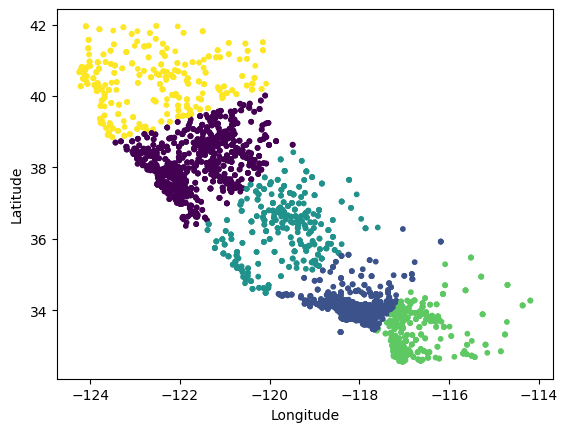

In [9]:
train_cleaned = create_geoclusters(train_cleaned)

In [10]:
print(train_cleaned.shape)
train_cleaned.head(2)

(4225, 35)


,Gender,Senior Citizen,Married,Dependents,Tenure in Months,Offer,Phone Service,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Satisfaction Score,Customer Status,Churn Value,Churn Category,Churn Reason,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,GeoCluster
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6518-PPLMZ,Male,No,Yes,Yes,53,No Offer,Yes,No,No,No Internet,0,No,No,No,No,No,No,No,No,Two Year,Yes,Credit Card,19.40,3,Stayed,0,No Churn,No Churn,20.950000,0.0,0.0,25.32,46.270000,2+,0.0
0060-FUALY,Female,No,Yes,No,59,Offer B,Yes,Yes,Yes,Fiber Optic,14,Yes,Yes,No,No,Yes,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,94.75,3,Stayed,0,No Churn,No Churn,94.875424,0.0,0.0,16.39,111.265424,2+,1.0


In [11]:
# create table that counts combinations of 'Streaming Music', 'Streaming TV', and 'Streaming Movies' columns
combination_counts = train_cleaned.groupby(['Streaming Music', 'Streaming TV', 'Streaming Movies']).size().reset_index(name='Counts')
print(combination_counts)

  Streaming Music Streaming TV Streaming Movies  Counts
0              No           No               No    2047
1              No           No              Yes      73
2              No          Yes               No     428
3              No          Yes              Yes     164
4             Yes           No               No      64
5             Yes           No              Yes     433
6             Yes          Yes               No      21
7             Yes          Yes              Yes     995


In [12]:
# create table that counts combinations of 'Streaming Music', 'Streaming TV', and 'Streaming Movies' columns
combination_counts = train_cleaned.groupby(['Device Protection Plan', 'Premium Tech Support', 'Online Security', 'Online Backup']).size().reset_index(name='Counts')
print(combination_counts)

   Device Protection Plan Premium Tech Support Online Security Online Backup  \
0                      No                   No              No            No   
1                      No                   No              No           Yes   
2                      No                   No             Yes            No   
3                      No                   No             Yes           Yes   
4                      No                  Yes              No            No   
5                      No                  Yes              No           Yes   
6                      No                  Yes             Yes            No   
7                      No                  Yes             Yes           Yes   
8                     Yes                   No              No            No   
9                     Yes                   No              No           Yes   
10                    Yes                   No             Yes            No   
11                    Yes               

In [13]:
# create feature engeneering function

def feature_engineering(df):
    """
    Function that performs the followting transformations:
    1) Create a new feature 'Streaming Services' that indicates if a customer has any streaming services
    2) Transfors 'Internet Type' into an ordereed categorical variable from lower to higher speed: 0 Cable, 1 DSL, 2 Fiber Optic
    3) Creates 'Value Added Services' feature that indicates if a customer has any of the following services: 'Device Protection Plan', 'Premium Tech Support', 'Online Security', 'Online Backup'
    4) Creates ordered "Phone Service" categorical variable: 0 'No Phone Service', 1 'Yes' and 2 'Yes_Multiple Lines' (when 'Phone Service' is 'Yes' and 'Multiple Lines' is 'Yes')
    5) Drop leakage columns for modelling
    """
    # 1. Create a new feature 'Streaming Services' that indicates if a customer has any streaming services and drops the original columns
    df['Streaming Services'] = np.where(
        (df['Streaming Music'] == 'Yes') | (df['Streaming TV'] == 'Yes') | (df['Streaming Movies'] == 'Yes'),
        'Yes',
        'No'
    )
    df = df.drop(columns=['Streaming Music', 'Streaming TV', 'Streaming Movies'])

    # 2. Transfors 'Internet Type' into an ordereed categorical variable from lower to higher speed: 0 Cable, 1 DSL, 2 Fiber Optic. Drop 'Internet Service' column.
    internet_type_mapping = {
        'No Internet': -1,
        'Cable': 0,
        'DSL': 1,
        'Fiber Optic': 2
    }
    df['Internet Type'] = df['Internet Type'].map(internet_type_mapping)
    df = df.drop(columns=['Internet Service'])

    # 3. Creates 'Value Added Services' feature that indicates if a customer has any of the following services: 'Device Protection Plan', 'Premium Tech Support', 'Online Security', 'Online Backup'. drops original columns.
    df['Value Added Services'] = np.where(
        (df['Device Protection Plan'] == 'Yes') | (df['Premium Tech Support'] == 'Yes') | (df['Online Security'] == 'Yes') | (df['Online Backup'] == 'Yes'),
        'Yes',
        'No'
    )
    df = df.drop(columns=['Device Protection Plan', 'Premium Tech Support', 'Online Security', 'Online Backup'])

    # 4. Creates ordered "Phone Service" categorical variable: 0 'No Phone Service', 1 'Yes' and 2 'Yes_Multiple Lines' (when 'Phone Service' is 'Yes' and 'Multiple Lines' is 'Yes'). Drops 'Multiple Lines' column.
    df['Phone Service'] = np.where(
        df['Phone Service'] == 'No',
        0,
        np.where(
            (df['Phone Service'] == 'Yes') & (df['Multiple Lines'] == 'Yes'),
            2,
            1
        )
    )
    df = df.drop(columns=['Multiple Lines'])

    # 5. drop leakage columns for modelling
    df = df.drop(columns=['Offer','Satisfaction Score','Customer Status', 'Churn Reason', 'Churn Category'])
      
    return df

In [14]:
train_fe = feature_engineering(train_cleaned)

In [15]:
# save train_cleaned dataframe
train_fe.to_parquet(
    "../data/intermediate_dfs/train_fe.parquet",
    engine="pyarrow",
    index=True
)

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#000000'>
    
# **3. Encoding and Scaling**</font>
</a>

In [16]:
# load train_fe.parquet as train_fe
train_fe = pd.read_parquet('../data/intermediate_dfs/train_fe.parquet')
print(train_fe.shape)
train_fe.head(2)

(4225, 23)


,Gender,Senior Citizen,Married,Dependents,Tenure in Months,Phone Service,Internet Type,Avg Monthly GB Download,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Churn Value,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,GeoCluster,Streaming Services,Value Added Services
Customer ID,,,,,,,,,,,,,,,,,,,,,,,
6518-PPLMZ,Male,No,Yes,Yes,53,1,-1,0,No,Two Year,Yes,Credit Card,19.40,0,20.950000,0.0,0.0,25.32,46.270000,2+,0.0,No,No
0060-FUALY,Female,No,Yes,No,59,2,2,14,Yes,Month-to-Month,Yes,Bank Withdrawal,94.75,0,94.875424,0.0,0.0,16.39,111.265424,2+,1.0,Yes,Yes


### 3.1. Data Encoding

In [17]:
# define enconding function
def encoding(df):
    """
    Function that encodes categorical variables according to fhe following rules:
    1. 'Yes'/'No' variables are encoded as 1/0
    2. 'Payment Method' variable is one-hot encoded
    3. 'Contract Type' and 'Number of Referrals_bins' variable are ordinally encoded: i) 'Month-to-Month' as 0, 'One Year' as 1, and 'Two Year' as 2; ii) '0' as 0, '1' as 1, and '2+' as 2
    4. 'Gender' is encoded as 1 for 'Male' and 0 for 'Female' and column name is changed to 'Male'
    
    """
    # 1. 'Yes'/'No' variables are encoded as 1/0
    yes_no_cols = df.select_dtypes(include=['object']).columns
    for col in yes_no_cols:
        if set(df[col].unique()) == {'Yes', 'No'}:
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # 2. 'Payment Method' variable is one-hot encoded and drop first to avoid multicollinearity
    df = pd.get_dummies(df, columns=['Payment Method'], drop_first=True)

    dummy_cols = [col for col in df.columns if col.startswith('Payment Method_')]
    df[dummy_cols] = df[dummy_cols].astype(int)


    # 3. 'Contract' and 'Number of Referrals_bins' variable are ordinally encoded: i) 'Month-to-Month' as 0, 'One Year' as 1, and 'Two Year' as 2; ii) '0' as 0, '1' as 1, and '2+' as 2
    contract_type_mapping = {
        'Month-to-Month': 0,
        'One Year': 1,
        'Two Year': 2
    }
    df['Contract Duration'] = df['Contract'].map(contract_type_mapping)
    df = df.drop(columns=['Contract'])
    
    referrals_bins_mapping = {
        '0': 0,
        '1': 1,
        '2+': 2
    }
    df['Number of Referrals_bins'] = df['Number of Referrals_bins'].map(referrals_bins_mapping).astype(int)
    
    # 4. 'Gender' is encoded as 1 for 'Male' and 0 for 'Female' and column name is changed to 'Male'
    df['Male'] = df['Gender'].map({'Male': 1, 'Female': 0})
    df = df.drop(columns=['Gender'])

    return df

In [18]:
train_encode = encoding (train_fe)
print(train_encode.shape)
print(train_encode.info())
train_encode.head(2)

(4225, 24)
<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 6518-PPLMZ to 2578-JQPHZ
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Senior Citizen                         4225 non-null   int64  
 1   Married                                4225 non-null   int64  
 2   Dependents                             4225 non-null   int64  
 3   Tenure in Months                       4225 non-null   int64  
 4   Phone Service                          4225 non-null   int32  
 5   Internet Type                          4225 non-null   int64  
 6   Avg Monthly GB Download                4225 non-null   int64  
 7   Unlimited Data                         4225 non-null   int64  
 8   Paperless Billing                      4225 non-null   int64  
 9   Monthly Charge                         4225 non-null   float64
 10  Churn Value                            4225 non-nul

,Senior Citizen,Married,Dependents,Tenure in Months,Phone Service,Internet Type,Avg Monthly GB Download,Unlimited Data,Paperless Billing,Monthly Charge,Churn Value,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,GeoCluster,Streaming Services,Value Added Services,Payment Method_Credit Card,Payment Method_Mailed Check,Contract Duration,Male
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,
6518-PPLMZ,0,1,1,53,1,-1,0,0,1,19.40,0,20.950000,0.0,0.0,25.32,46.270000,2,0.0,0,0,1,0,2,1
0060-FUALY,0,1,0,59,2,2,14,1,1,94.75,0,94.875424,0.0,0.0,16.39,111.265424,2,1.0,1,1,0,0,0,0


In [19]:
# save train_cleaned dataframe
train_encode.to_parquet(
    "../data/intermediate_dfs/train_encode.parquet",
    engine="pyarrow",
    index=True
)

### 3.2. Data Scaling

In [20]:
# define a function to scale data using RobustScaler
def scaling(df):
    """
    Function that scales the df using RobustScaler. If a column is non-numerical an error message is raised.
    """
    
    # print error message if any column is non-numerical
    non_numerical_cols = df.select_dtypes(exclude=['int64', 'int32', 'float64']).columns
    if len(non_numerical_cols) > 0:
        raise ValueError(f"The following columns are non-numerical: {non_numerical_cols.tolist()}. Please encode them before scaling.")
    
    # apply RobustScaler
    scaler = RobustScaler()

    df[df.columns] = scaler.fit_transform(df[df.columns])
    
    return df

In [21]:
train_scaled = scaling(train_encode)
print(train_scaled.shape)
train_scaled.head(2)

(4225, 24)


,Senior Citizen,Married,Dependents,Tenure in Months,Phone Service,Internet Type,Avg Monthly GB Download,Unlimited Data,Paperless Billing,Monthly Charge,Churn Value,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,GeoCluster,Streaming Services,Value Added Services,Payment Method_Credit Card,Payment Method_Mailed Check,Contract Duration,Male
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,
6518-PPLMZ,0.0,1.0,1.0,0.510638,0.0,-1.0,-0.708333,-1.0,0.0,-0.917042,0.0,-0.878128,0.0,0.0,0.076668,-0.764612,1.0,-0.333333,-1.0,-1.0,1.0,0.0,1.0,0.0
0060-FUALY,0.0,1.0,0.0,0.638298,1.0,0.5,-0.125000,0.0,0.0,0.441839,0.0,0.438626,0.0,0.0,-0.252488,0.296414,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,-1.0


In [22]:
train_scaled.describe()

,Senior Citizen,Married,Dependents,Tenure in Months,Phone Service,Internet Type,Avg Monthly GB Download,Unlimited Data,Paperless Billing,Monthly Charge,Churn Value,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,GeoCluster,Streaming Services,Value Added Services,Payment Method_Credit Card,Payment Method_Mailed Check,Contract Duration,Male
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,0.164734,0.489231,0.229112,0.079330,0.336095,-0.063077,0.138195,-0.328757,-0.396450,-0.101703,0.265325,-0.099723,0.100838,0.430990,-0.004179,-0.081621,0.384260,0.130888,-0.484497,-0.399527,0.392663,0.054438,0.383314,-0.490178
std,0.370984,0.499943,0.420311,0.524791,0.642325,0.595803,0.850690,0.469817,0.489218,0.548017,0.441559,0.543088,0.607593,2.778463,0.568056,0.590987,0.444453,0.451323,0.499819,0.489859,0.488401,0.226907,0.425560,0.499963
min,0.000000,0.000000,0.000000,-0.595745,-1.000000,-1.000000,-0.708333,-1.000000,-1.000000,-0.929666,0.000000,-1.005928,0.000000,0.000000,-0.856616,-1.223400,0.000000,-0.333333,-1.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,-0.425532,0.000000,-0.500000,-0.583333,-1.000000,-1.000000,-0.642020,0.000000,-0.639003,0.000000,0.000000,-0.511611,-0.603931,0.000000,-0.333333,-1.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.574468,1.000000,0.500000,0.416667,0.000000,0.000000,0.357980,1.000000,0.360997,0.000000,0.000000,0.488389,0.396069,1.000000,0.666667,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,0.914894,1.000000,0.500000,2.833333,0.000000,0.000000,0.874662,1.000000,0.894171,12.946667,80.000000,0.985993,1.170967,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000


In [23]:
# save dataframe
train_scaled.to_parquet(
    "../data/intermediate_dfs/train_scaled.parquet",
    engine="pyarrow",
    index=True
)